# DBSCAN clustering to reduce Google location history data set

See [this blog post](http://geoffboeing.com/2016/06/mapping-google-location-history-python/) for my full write-up of this project, or [this one](http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) for more about using Python's scikit-learn implementation of DBSCAN to reduce the size of a spatial data set.

This notebook reduces the size of a Google location history data set down to a set of spatially representative points, with DBSCAN clustering. Visit https://accounts.google.com/ServiceLogin?service=backup to download your Google location history as a JSON file called LocationHistory.json.

In [1]:
# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt

# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

## Prep the data set

In [2]:
# load the full location history json file downloaded from google
df_gps = pd.read_json('data/LocationHistory.json')
print('There are {:,} rows'.format(len(df_gps)))

There are 1,574,479 rows


In [3]:
# parse lat, lon from the dict inside the locations column and convert to decimalized degrees
df_gps['lat'] = df_gps['locations'].map(lambda x: x['latitudeE7']) / 10.**7
df_gps['lon'] = df_gps['locations'].map(lambda x: x['longitudeE7']) / 10.**7

In [4]:
# parse timestamp in seconds from locations column and convert to datetime
df_gps['timestamp_s'] = (df_gps['locations'].map(lambda x: x['timestampMs']).astype(float) / 1000).astype(int)
df_gps['datetime'] = pd.to_datetime(df_gps['timestamp_s'], unit='s')

In [5]:
# filter out points with altitudes above 3000 meters to remove airplane data
df_gps['altitude'] = df_gps['locations'].map(lambda x: x['altitude'] if 'altitude' in x else None)
mask = (df_gps['altitude'] < 3000) | (pd.isnull(df_gps['altitude']))
df_gps = df_gps[mask]

The scikit-learn DBSCAN haversine distance metric requires data in the form of [latitude, longitude] and both inputs and outputs are in units of radians.

In [6]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [7]:
# df_gps = df_gps.iloc[range(0, len(df_gps), int(len(df_gps)/5000))] #uncomment to cluster only a sample

## Define the clustering functions

In [8]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [9]:
def dbscan_reduce(df, epsilon, x='lon', y='lat'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df.as_matrix(columns=[y, x])    
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return rs

## Now cluster the data

In [10]:
# first cluster the full gps location history data set coarsely, with epsilon=5km in radians
eps_rad = 5 / kms_per_radian
df_clustered = dbscan_reduce(df_gps, epsilon=eps_rad)

Number of clusters: 447
Clustered 1,574,196 points down to 447 points, for 99.97% compression in 25,685.37 seconds.


The previous clustering reduces dense clusters of points to a single point. Because min_samples=1, no point is noise - if there was a single gps reading in the middle of nowhere, it will be retained as a cluster/point. If the points were too dense along a linear strip, such as a highway, it will remove the entire line of points and leave just one behind, in the middle. To fix this, let's thin out the data set by retaining every *n*th point as df_sampled. Then, combine df_sampled with df_clustered, and re-cluster once again to reduce the thinned-out data set. The final product will retain lonely points in the middle of nowhere (that would otherwise possibly be lost by merely sampling every *n*th point) and will not strip out long linear corridors of dense points (that were removed in the first clustering step).

In [11]:
# next, sample every nth row (where n=sample_rate) of the full gps location history data set
sample_rate = 20
df_sampled = df_gps.iloc[range(0, len(df_gps), sample_rate)]
len(df_sampled)

78710

In [12]:
# combine the clustered and sampled sets
df_combined = pd.concat([df_clustered, df_sampled], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

In [13]:
# then reduce by clustering again, finely this time with epsilon=0.1km in radians
eps_rad = 0.1 / kms_per_radian
df_final = dbscan_reduce(df_combined, epsilon=eps_rad)

Number of clusters: 4,714
Clustered 79,157 points down to 4,714 points, for 94.04% compression in 56.08 seconds.


In [14]:
# save to csv
df_final.to_csv('data/location-history-clustered.csv', index=False, encoding='utf-8')

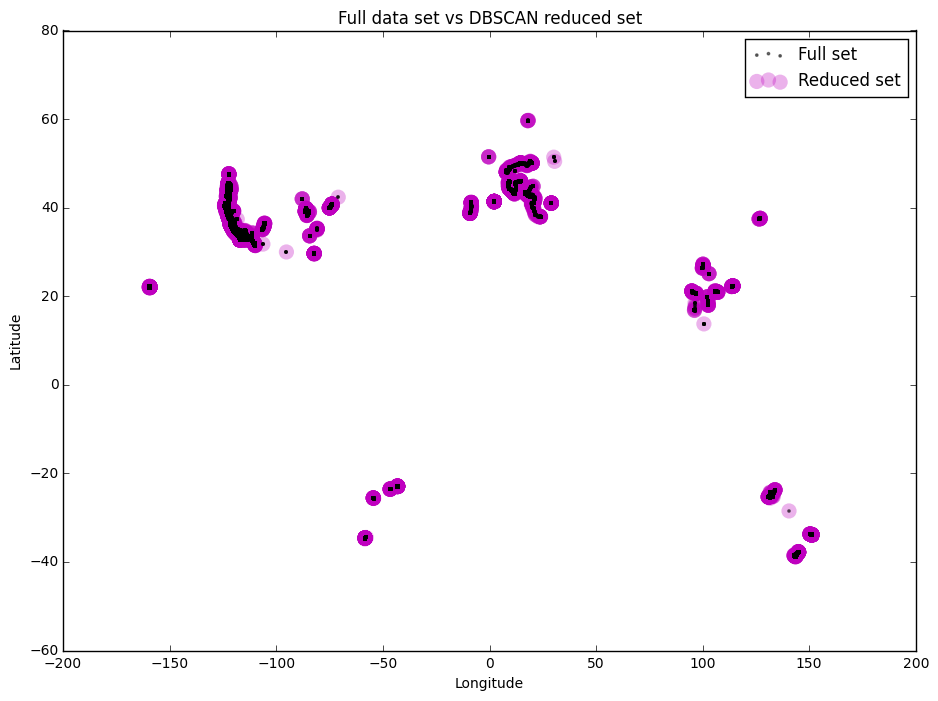

In [15]:
# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['lon'], df_final['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_gps['lon'], df_gps['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

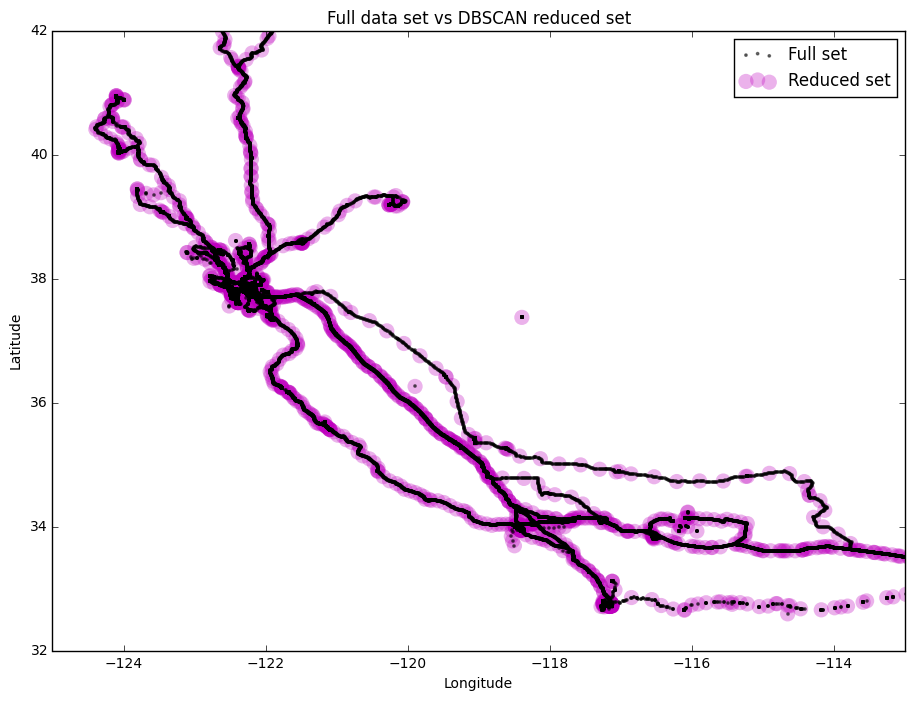

In [16]:
# show a map of only the california data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['lon'], df_final['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_gps['lon'], df_gps['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-125, -113])
ax.set_ylim([32, 42])
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

Due to a memory issue introduced in newer versions of scikit-learn, you may have to downgrade to an earlier version such as 0.15 to get the DBSCAN clustering to run without errors if you have a huge dataset. 

To do this with Anaconda, run: `conda install scikit-learn=0.15`

Or create a virtual environment, like: `conda create -n clusterenv python=3.4 scikit-learn=0.15 matplotlib pandas jupyter`, and then `pip install geopy` and `shapely`. If you're on Windows, pip install the shapely wheel [from Gohlke](http://www.lfd.uci.edu/~gohlke/pythonlibs/#shapely).

More info:
  - https://stackoverflow.com/questions/24024510/clustering-500-000-geospatial-points-in-python
  - https://github.com/scikit-learn/scikit-learn/issues/5275
  - https://github.com/scikit-learn/scikit-learn/issues/6256
  - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
  - https://en.wikipedia.org/wiki/Haversine_formula